# Model validation with external data
In this notebook I will try to get the performance of the model on an external dataset I have obtained from a public repository, like ChEMBL, PubChem, Therapeutics Data Commons or MoleculeNet.

I need to find a dataset for which experimental data exactly as the one used to train my model of interest is available.

In [6]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

import warnings

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import inchi

warnings.filterwarnings('ignore')

# To gain access function in src directory
%run ../src/smiles_processing.py

In [7]:
# Read the validation input file
model_val_file = "../data/model_val_set.csv"
val_data = pd.read_csv(model_val_file, header=0)
val_smiles = val_data["SMILES"].tolist()
val_data["standardized inchikey"] = ""

# Extract Training set
input_train_file = "../data/train_validation_cardio_tox_data.csv"
input_train = pd.read_csv(input_train_file, header=0, usecols=[1])
input_train["inchikey"] = ""
train_rows = input_train["smiles"].tolist()

,InChl Key,SMILES,Activity,Database,standardized inchikey
0,FKUXHLWBOQAISV-UHFFFAOYSA-N,CN(CCO)CCN1CCCc2cc(NC(=N)c3cccs3)ccc21,1,ChEMBL,
1,GDMWZTBOBNMXTL-UHFFFAOYSA-N,CCN(C)CCN1CCCc2cc(NC(=N)c3cccs3)ccc21,1,ChEMBL,
2,VWNMWKSURFWKAL-HXOBKFHXSA-N,COc1ccc2nccc(C(=O)CC[C@@H]3CCN(CC#Cc4cc(F)cc(F...,1,ChEMBL,
3,ONYWALXTZFPKAS-XHCCPWGMSA-N,CC1CCN([C@H](c2ccc(F)cc2)c2ccc([C@@H](C)C(=O)O...,0,ChEMBL,
4,ONYWALXTZFPKAS-PPHZAIPVSA-N,CC1CCN([C@@H](c2ccc(F)cc2)c2ccc([C@H](C)C(=O)O...,1,ChEMBL,


In [8]:
# Create inchikey for train set
inchikey_train_list = []

# Calculate each Inchikey per molecule
for smiles in input_train.iloc[:, 0]:
    mol_train = Chem.MolFromSmiles(smiles)
    inchikey_train = inchi.MolToInchiKey(mol_train)
    inchikey_train_list.append(inchikey_train)
    
inchikey_train_list

input_train["inchikey"] = inchikey_train_list

,smiles,inchikey
0,Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F,PMWZSLRPVRCNKM-UHFFFAOYSA-N
1,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,IOVNPTLMMFSPCO-UHFFFAOYSA-N
2,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,BSPCGOZVENCINN-AKAXFMLLSA-N
3,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,UQBOMAVTFFNGLT-PVARCSIZSA-N
4,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,DEYZGKXTVSBRIY-UHFFFAOYSA-N


In [9]:
# Create lists to store standardized Inchikey for validation set
inchikey_val_list1 = []

# Calculate each Inchikey per molecule
for smiles in val_data.iloc[:, 1]:
    mol_val = Chem.MolFromSmiles(smiles)
    inchikey_val = inchi.MolToInchiKey(mol_val)
    inchikey_val_list1.append(inchikey_val)
    
val_data["standardized inchikey"] = inchikey_val_list1

,InChl Key,SMILES,Activity,Database,standardized inchikey
0,FKUXHLWBOQAISV-UHFFFAOYSA-N,CN(CCO)CCN1CCCc2cc(NC(=N)c3cccs3)ccc21,1,ChEMBL,FKUXHLWBOQAISV-UHFFFAOYSA-N
1,GDMWZTBOBNMXTL-UHFFFAOYSA-N,CCN(C)CCN1CCCc2cc(NC(=N)c3cccs3)ccc21,1,ChEMBL,GDMWZTBOBNMXTL-UHFFFAOYSA-N
2,VWNMWKSURFWKAL-HXOBKFHXSA-N,COc1ccc2nccc(C(=O)CC[C@@H]3CCN(CC#Cc4cc(F)cc(F...,1,ChEMBL,VWNMWKSURFWKAL-HXOBKFHXSA-N
3,ONYWALXTZFPKAS-XHCCPWGMSA-N,CC1CCN([C@H](c2ccc(F)cc2)c2ccc([C@@H](C)C(=O)O...,0,ChEMBL,ONYWALXTZFPKAS-XHCCPWGMSA-N
4,ONYWALXTZFPKAS-PPHZAIPVSA-N,CC1CCN([C@@H](c2ccc(F)cc2)c2ccc([C@H](C)C(=O)O...,1,ChEMBL,ONYWALXTZFPKAS-PPHZAIPVSA-N


In [11]:
#Remove repeated molecules must be eliminated to avoid bias
common_inchikey = val_data["standardized inchikey"].isin(input_train["inchikey"])
common_inchikey = val_data[common_inchikey]

new_val_data1 = val_data.drop(common_inchikey.index, axis=0)
new_val_data1 = new_val_data1.reset_index(drop=True)
new_val_data1 = new_val_data1.drop(columns=['Database'])

# Create a new dataset
ext_validation_set1 = new_val_data1[0:500]

len(common_inchikey)

5206

In [21]:
#Remove repeated molecules must be eliminated to avoid bias
common_smiles = val_data["SMILES"].isin(input_train["smiles"])
common_data = val_data[common_smiles]

new_val_data = val_data.drop(common_data.index, axis=0)
new_val_data = new_val_data.reset_index(drop=True)
new_val_data1 = new_val_data.drop(columns=['Database'])

# Create a new dataset
ext_validation_set = new_val_data1[0:500]

len(common_data)

5025

In [23]:
# Extract smiles
ext_validation_data = ext_validation_set1["SMILES"].tolist()

# Standardise smile
ext_stand_smile = standardise_smiles(ext_validation_data)

In [24]:
# Create lists to store Inchikey
inchikey_val_list = []

# Calculate each Inchikey per molecule
for smiles in ext_stand_smile:
    mol = Chem.MolFromSmiles(smiles)
    inchikey = inchi.MolToInchiKey(mol)
    inchikey_val_list.append(inchikey)

In [25]:
# Store smile and inchikey in a zipped list
final_val_data = list(zip(ext_stand_smile, inchikey_val_list1))

# Write the data to the CSV file
with open("../data/new_validation_data.csv", 'w', newline='') as n:
    csv_writer = csv.writer(n)
    
    # Write header
    csv_writer.writerow(['smiles', 'inchikey'])
    
    # Write data
    csv_writer.writerows(final_val_data)

In [26]:
# Prepare the prediction for metrics evaluation

# Extract the rows into a list for test set
test_rows = ext_validation_set["Activity"].squeeze().tolist()

# Read the validation input file
model_val_pred_file = "../data/ext_val_smile_inchi.csv"
val_pred_data = pd.read_csv(model_val_pred_file, header=0)
val_pred_prob = val_pred_data["probability"].squeeze().tolist()

val_pred_array = np.array([float(value) for value in val_pred_prob])
auc_pred_array = np.delete(val_pred_array, 121)
val_pred_list = np.where(val_pred_array > 0.5, 1, 0).tolist()

#Create dataframe containing both probabilities
val_test_prob = pd.DataFrame()
val_test_prob["Test Probability"] = test_rows
val_test_prob["Model Probability"] = val_pred_list
new_val_test_prob = val_test_prob.drop(121)

# Evaluate model using metrics below
auc_val = roc_auc_score(new_val_test_prob["Test Probability"], auc_pred_array)

tn, fp, fn, tp = confusion_matrix(new_val_test_prob["Test Probability"], new_val_test_prob["Model Probability"]).ravel()
specificity_val = tn / (tn + fp)
sensitivity_val = tp / (tp + fn)
NPV_val = tn / (tn + fn)
PPV_val = tp / (tp + fp)

Accuracy_val = balanced_accuracy_score(new_val_test_prob["Test Probability"], new_val_test_prob["Model Probability"])
MCC_val = matthews_corrcoef(new_val_test_prob["Test Probability"], new_val_test_prob["Model Probability"])

In [27]:
# Put values in a table
ext_val_metric_table = PrettyTable(["Evaluation data", "Method", "AUC", "MCC", "NPV", "ACC", "PPV", "SPE", "SEN", "B-ACC"])

ext_val_metric_data = ["External dataset", "eos2ta5", round(auc_val, 3), round(MCC_val, 3), round(NPV_val, 3), round(Accuracy_val, 3), 
                       round(PPV_val, 3), round(specificity_val, 3), round(sensitivity_val, 3), round(Accuracy_val, 3)]

# Add the calculated values to the table created
ext_val_metric_table.add_row(ext_val_metric_data)

print("Metric value on external dataset used on Ersilia Model Hub")

# Print out the table
print(ext_val_metric_table)

Metric value on external dataset used on Ersilia Model Hub
+------------------+---------+-------+------+------+-------+-------+-------+-------+-------+
| Evaluation data  |  Method |  AUC  | MCC  | NPV  |  ACC  |  PPV  |  SPE  |  SEN  | B-ACC |
+------------------+---------+-------+------+------+-------+-------+-------+-------+-------+
| External dataset | eos2ta5 | 0.683 | 0.32 | 0.63 | 0.659 | 0.693 | 0.725 | 0.592 | 0.659 |
+------------------+---------+-------+------+------+-------+-------+-------+-------+-------+


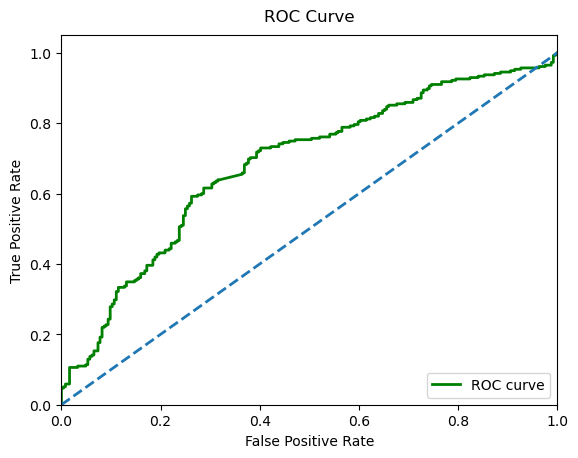

In [28]:
fpr, tpr, thresholds = roc_curve(new_val_test_prob["Test Probability"], auc_pred_array)

# Plot ROC_Curve
plt.figure()

plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

plt.title("ROC Curve", pad=10)
plt.show()